In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import signatory
import torch

from regimedetection.examples.brownianpaths.utils import simulate_gbm_process
from regimedetection.src.clustering import delta_k_t
from regimedetection.src.clustering import get_similarities_matrix
from regimedetection.src.clustering import get_space_distances
from regimedetection.src.clustering import get_space_similarities
from regimedetection.src.clustering import get_transition_matrix_from_similarities_matrix
from regimedetection.src.clustering import multiscale_k_prototypes
from regimedetection.src.kernels import make_rbf_kernel
from regimedetection.src.kernels import make_mmd_estimate_metric_from_kernel
from regimedetection.src.similarities import make_gaussian_similarity
from regimedetection.src.utils.plot import make_colours

In [2]:
sns.set_style("dark")

### Setup

In [3]:
n_time_steps = 100
points_per_cluster = 5
paths_per_point = 10
logsignature_depth = 5

rbf_kernel_sigma = 0.1
gaussian_similarity_sigma = 0.15

time_steps = np.linspace(0, 1, n_time_steps)

In this context, a **point** is defined to be a collection of logsignatures of Brownian paths. Here, we take a collection of 5 paths, time-augment, and take the logsignature (up to some depth) in order to get a collection of 5 logsignatures which represent the point. In this example, within each point, each path is generated using the same $(\mu, \sigma)$ values.

A **cluster** is, as usual, some collection of *similar* points. Here *similar* is with respect to a metric which has yet to be defined.

In order to simulate clusters, for each of the specified $(\mu, \sigma)$ pairs below, we generate `points_per_cluster * paths_per_point` GBM paths with the specified $\mu$, $\sigma$ values. We plot these first then compute logsignatures.

In [4]:
cluster_parameters = (
    (0.15, 0.15),
    (0.15, 0.35),
    (0.05, 0.15),
    (0.05, 0.35)
)

In [5]:
n_points = len(cluster_parameters) * points_per_cluster
n_paths_per_cluster = points_per_cluster * paths_per_point
n_paths = n_points * paths_per_point

point_colours = make_colours(n_points)

For efficiency, we generate a 2-dimensional array of path innovations. Iterative over each cluster $(\mu, \sigma)$ pair, we populate this paths array with the relevant paths. This allows one call to `signatory.logsignature` in order to compute the required signature transforms.

In [6]:
paths = np.empty(shape=(n_paths, n_time_steps))

for cluster_idx, (mu, sigma) in enumerate(cluster_parameters):
    cluster_paths = simulate_gbm_process(
        time_steps,
        n_paths_per_cluster,
        mu,
        sigma
    )
    
    cluster_start_idx = cluster_idx * n_paths_per_cluster
    cluster_end_idx = cluster_start_idx + n_paths_per_cluster
    
    paths[cluster_start_idx : cluster_end_idx] = cluster_paths

### Plot of Point Paths

We can separate out which paths belong to which point and plot these

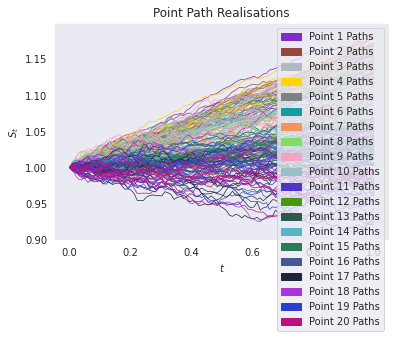

In [7]:
for point_number, point_colour in enumerate(point_colours):
    point_start_idx = point_number * paths_per_point
    point_end_idx = point_start_idx + paths_per_point
    
    point_paths = paths[point_start_idx : point_end_idx]
    
    plt.plot(
        time_steps,
        point_paths.T,
        color=point_colour,
        lw=0.7
    )
    
label_entries = tuple(
    mpatches.Patch(color=point_colour, label=f"Point {point_number+1} Paths")
    for point_number, point_colour in enumerate(point_colours)
)

plt.legend(handles=label_entries)

plt.title("Point Path Realisations")# TODO: Add MMD estimate function. Easy given the above and some tiling
#   - Note: Once this is done this example should flow quite easily from the previous work

plt.xlabel("$t$")
plt.ylabel("$S_t$")
plt.show()

### Computing Logsignatures & Defining Points

In [8]:
time_augmented_paths = np.empty(shape=(n_paths, n_time_steps, 2))
time_augmented_paths[..., 0] = time_steps
time_augmented_paths[..., 1] = paths

In [9]:
logsignatures = signatory.logsignature(
    torch.from_numpy(time_augmented_paths),
    depth=logsignature_depth
).numpy()

The points in our space are collections of these logsignatures

In [10]:
points = np.array(np.split(logsignatures, n_points))

# Clustering

Let's take the *MMD Estimate* metric induced by the [*Radial Basis Function Kernel*](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), given by

$$
K^{\sigma}(x, y) := \exp \left\{ - \frac{\lvert\lvert x - y \rvert\rvert^2}{2\sigma^2} \right\}
$$

In [11]:
# Generates a vectorized RBF Kernel function 
rbf_kernel = make_rbf_kernel(rbf_kernel_sigma)
mmd_estimate_metric = make_mmd_estimate_metric_from_kernel(rbf_kernel)

gaussian_similarity = make_gaussian_similarity(gaussian_similarity_sigma)

### Aside: Trying to find good separation between points

In [12]:
base_point = points[0]
close_point = points[1]
far_point = points[-1]

def print_distances(kernel_sigma):
    kernel = make_rbf_kernel(kernel_sigma)
    metric = make_mmd_estimate_metric_from_kernel(kernel)
    
    close_distance = metric(base_point, close_point)
    far_distance = metric(base_point, far_point)

    print("Close Distance:", close_distance)
    print("Far Distance:", far_distance)
    
sigma_values = [0.01, 0.1, 0.2, 0.3, 0.5, 1]

for sigma in sigma_values:
    print(f"Sigma = {sigma}")
    print_distances(sigma)
    print()

Sigma = 0.01
Close Distance: 0.17910334460241428
Far Distance: 0.5458042619165501

Sigma = 0.1
Close Distance: 0.0031144216910941047
Far Distance: 1.3225382681716713

Sigma = 0.2
Close Distance: 0.0008538817373107133
Far Distance: 0.5655641640750966

Sigma = 0.3
Close Distance: 0.000386241564623635
Far Distance: 0.2828034354794944

Sigma = 0.5
Close Distance: 0.00014031388795054944
Far Distance: 0.10842835486568392

Sigma = 1
Close Distance: 3.5213372108655605e-05
Far Distance: 0.027852687063760095



### Aside ends here

In [13]:
similarities_matrix = get_similarities_matrix(
    points, mmd_estimate_metric, gaussian_similarity
)

transition_matrix = get_transition_matrix_from_similarities_matrix(
    similarities_matrix
)

### Eigengap Plot

In [14]:
evalues = np.linalg.eig(transition_matrix)[0]

# Sort eigenvalues from largest to smallest
idx = evalues.argsort()[::-1]
evalues = evalues[idx]

In [15]:
# Cluster numbers considered - most general would be {1, ..., N} where
# N = number of points
k_values = np.arange(1, 6)

# Number of steps considered - could be more clever about this and infer
# from the dataset what the maximum number of steps should be, e.g. by
# checking when the 1-clustering starts to be the recommendation
t_values = np.logspace(start=0, stop=5, num=1000)

$\Delta_K(t) = |\lambda_{K}|^t - |\lambda_{K+1}|^t$ for $k \in \{1, 2, 3, 4, 5\}$, $0 \leq t \leq 10^6$

In [16]:
k_colours = make_colours(len(k_values))

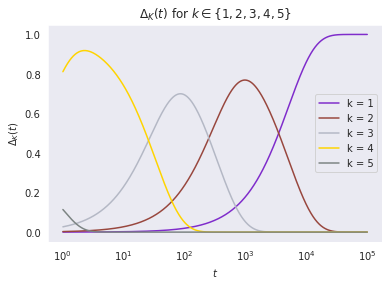

In [17]:
delta_k_t_values = delta_k_t(k_values, t_values, evalues)

for idx, k in enumerate(k_values):
    plt.plot(
        t_values,
        delta_k_t_values[idx],
        label=f"k = {k}",
        color = k_colours[idx]
    )
    
plt.xscale("log")
plt.xlabel("$t$")
plt.ylabel("$\Delta_K(t)$")
plt.title("$\Delta_K(t)$ for $k \in \{1, 2, 3, 4, 5 \}$")
plt.legend()
plt.show()

$\Delta(t) = \max_{K} \Delta_K(t)$ for $0 \leq t \leq 10^6$:

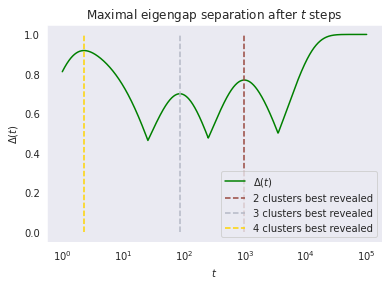

In [18]:
delta_t_values = delta_k_t_values.max(axis=0)

plt.plot(t_values, delta_t_values, label="$\Delta(t)$", color="green")

# Add lines to show local maxima of delta_k_t for appropriate values of k
for idx, t_idx in enumerate(delta_k_t_values.argmax(axis=1)):
    if idx == 0:
        continue
    
    k = k_values[idx]
    t = t_values[t_idx]
    
    if delta_k_t_values[:, t_idx].argmax(axis=0) == idx:
        plt.plot(
            [t, t],
            [0, 1],
            label=f"{k} clusters best revealed",
            color=k_colours[idx],
            linestyle="dashed"
        )

plt.title("Maximal eigengap separation after $t$ steps")
plt.xlabel("$t$")
plt.ylabel("$\Delta(t)$")

plt.xscale("log")
plt.legend()
plt.show()

Number of clusters best revealed by $t$ steps, $K(t)$:

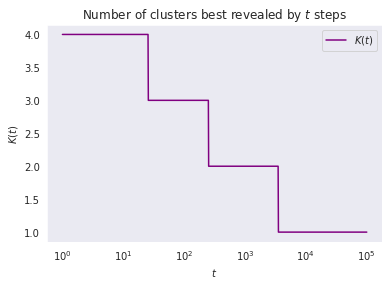

In [19]:
clusters_best_revealed = delta_k_t_values.argmax(axis=0) + 1

plt.plot(t_values, clusters_best_revealed, label="$K(t)$", color="purple")

plt.title("Number of clusters best revealed by $t$ steps")
plt.xlabel("$t$")
plt.ylabel("$K(t)$")

plt.xscale("log")
plt.legend()
plt.show()

In [20]:
suggested_partitions = multiscale_k_prototypes(
    transition_matrix,
    max_steps_power = 5,
    max_clusters = 6
)

In [21]:
plotted_paths_per_cluster = 10

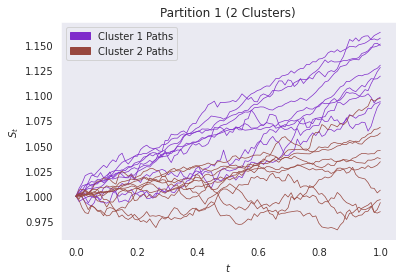

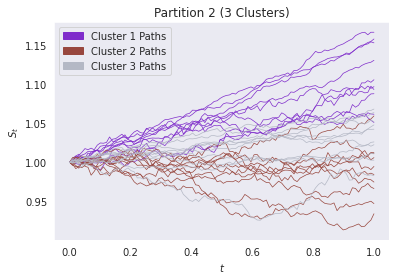

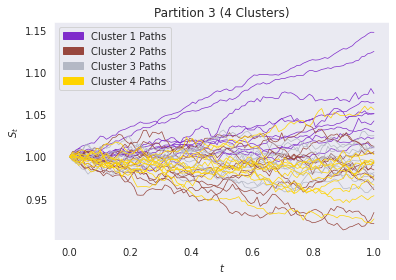

In [22]:
for partition_idx, (partition, partition_suitability) in enumerate(suggested_partitions):
    
    plot_legend_entries = []
    cluster_colours = make_colours(len(partition))
    
    for cluster_idx, cluster_indices in enumerate(partition):
        cluster_colour = cluster_colours[cluster_idx]
        
        suggested_cluster_path_indices = np.concatenate(
            tuple(
                np.arange(
                    paths_per_point * point_idx,
                    paths_per_point * (point_idx + 1)
                )
                for point_idx in cluster_indices
            )
        )
        
        suggested_cluster_paths = paths[suggested_cluster_path_indices]
        plotted_path_indices = np.random.choice(
            len(suggested_cluster_paths),
            size = plotted_paths_per_cluster,
            replace = False
        )
        plotted_paths = suggested_cluster_paths[plotted_path_indices]
        
        for path in plotted_paths:
            plt.plot(
                time_steps,
                path,
                color = cluster_colour,
                lw = 0.7
            )
        
        plot_legend_entries.append(
            mpatches.Patch(
                color = cluster_colour,
                label = f"Cluster {cluster_idx + 1} Paths"
            )
        )

    plt.title(f"Partition {partition_idx+1} ({len(partition)} Clusters)")
    plt.xlabel('$t$')
    plt.ylabel('$S_t$')
    plt.legend(handles=plot_legend_entries)
    plt.show()